In [1]:
import xarray as xr
import glob
import numpy as np
import matplotlib.pyplot as plt
from utils import *

In [183]:
import joblib
from joblib import Parallel,delayed

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [186]:
# Setup your PBSCluster
import dask
from dask_jobqueue import PBSCluster
from dask.distributed import Client
ncores=1
nmem='10GB'
cluster = PBSCluster(
    cores=ncores, # The number of cores you want
    memory=nmem, # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    resource_spec='select=1:ncpus='+str(ncores)+':mem='+nmem, # Specify resources
    account='P93300041', # Input your project ID here
    walltime='02:00:00', # Amount of wall time
)

In [187]:
cluster.scale(30)
client = Client(cluster)

### some files and funcs

In [45]:
d='/glade/derecho/scratch/slevis/archive/ctsm53017_f19_BNF_hist/lnd/hist/'
files=sorted(glob.glob(d+'*h1*'))

In [3]:
ds=xr.open_dataset(files[0])

In [5]:
tmp=xr.open_dataset('/glade/work/djk2120/ppe_savs/pbmean/metrics_h1.nc')

In [7]:
from statsmodels.stats.weightstats import DescrStatsW
def getq(x,a,q):
    wq = DescrStatsW(data=x.values.ravel(), weights=a.values.ravel())
    qq=wq.quantile(probs=q, return_pandas=False)
    return qq[0]

### h0 data

In [8]:
#h0 landarea array
tmp0=xr.open_dataset(files[0])
a=(tmp0.landfrac*tmp0.area*(tmp0.lat>-60)).fillna(0)  #mask antarctica
#h0 features
h0=xr.open_dataset('fullgrid/ctsm53017_f19_BNF_gc_metrics.nc')
dvs=[v for v in h0.data_vars]
dvs.remove('yr1')
dvs.remove('yr2')

In [36]:
#normalize based on area-weighted 5th/95th percentiles
x=h0['FCEV_mean'].isel(epoch=0)
m=xr.DataArray([h0[v].isel(epoch=i) for i in range(4) for v in dvs],dims=['metric',*x.dims])
q1=xr.DataArray([getq(m,a,0.05) for m in m],dims='metric')
q2=xr.DataArray([getq(m,a,0.95) for m in m],dims='metric')
normal=(m-q1)/(q2-q1)

In [48]:
#tile to pft
tmp=xr.open_dataset(files[0])
nlon=len(normal.lon)
nlat=len(normal.lat)
ix=((tmp.pfts1d_jxy-1)*nlon+tmp.pfts1d_ixy-1).astype(int)
h0norm=normal.stack({'gc':['lat','lon']}).isel(gc=ix)

### transient pft area

In [104]:
def pp(ds):
    return ds['pfts1d_wtgcell']
wtg=xr.open_mfdataset(files[::12],combine='nested',concat_dim='year',preprocess=pp)
wtg['year']=range(1920,2024)
apft=(a.stack({'gc':['lat','lon']}).isel(gc=ix)*wtg).compute()

In [105]:
x=apft.groupby(tmp.pfts1d_itype_veg).sum().compute()

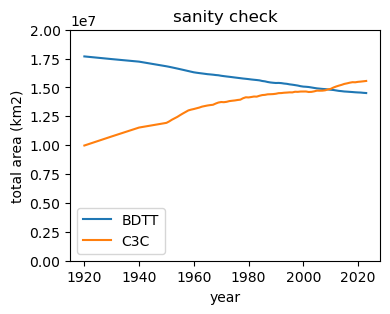

In [113]:
plt.figure(figsize=[4,3])
x.isel(pfts1d_itype_veg=4).plot()
x.isel(pfts1d_itype_veg=15).plot()

plt.legend(['BDTT','C3C'])
plt.ylim([0,2e7])
plt.ylabel('total area (km2)')
plt.title('sanity check');

### h1 data

In [69]:
h1=xr.open_dataset('fullgrid/ctsm53017_f19_BNF_pft_metrics.nc')
dvs=[v for v in h1.data_vars]
dvs.remove('yr1')
dvs.remove('yr2')

In [115]:
aa=apft.mean(dim='year').compute()
m=xr.DataArray([h1[v].isel(epoch=i) for i in range(4) for v in dvs],dims=['metric','pft'])
q1=xr.DataArray([getq(m,aa,0.05) for m in m],dims='metric')
q2=xr.DataArray([getq(m,aa,0.95) for m in m],dims='metric')
h1norm=(m-q1)/(q2-q1)

In [247]:
pft=fg.pfts1d_itype_veg*1000 #asserts that pft must match
nmetrics=xr.concat([h0norm,h1norm,pft],dim='metric').fillna(0)

1.0


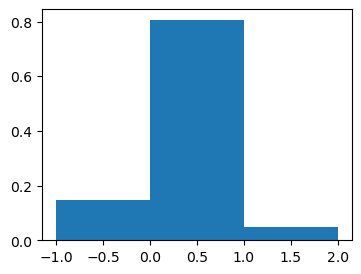

In [248]:
plt.figure(figsize=[4,3])
c,bins,f=plt.hist(nmetrics.values.ravel(),-1+np.arange(4),density=True);
print(c.sum()) #should be very close to 1 if normalized properly

### classify the fullgrid patches
 - pft match asserted

In [249]:
fg=xr.open_dataset(files[0])

In [250]:
d='/glade/derecho/scratch/linnia/BNF_v2.n01_ctsm5.3.012_transient_lhc0000/run/'
sgfiles=sorted(glob.glob(d+'*h1*'))
sg=xr.open_dataset(sgfiles[0])

In [251]:
#subset sparsegrid data from fullgrid
dims=['pfts1d_ixy','pfts1d_jxy','pfts1d_itype_veg']
xs=[(fg[v]==xr.DataArray(sg[v],dims='pftsg')) for v in dims]
fgmap=((xs[0]*xs[1]*xs[2])*fg.pft).max(dim='pft')
centroids=nmetrics.isel(pft=fgmap)

In [252]:
def findc(x,centroids):
    c=((x-centroids)**2).sum(dim='metric').argmin(dim='pftsg')
    return c

In [253]:
#split into manageable chunks
npft=len(nmetrics.pft)
xs=[nmetrics.isel(pft=range(i*100,min(npft,(i+1)*100))).compute() for i in range(1+int(npft/100))]
#classify in parallel
with joblib.parallel_config(backend="dask"):
    results=Parallel(verbose=1)(delayed(findc)(x,centroids) for x in xs)

[Parallel(n_jobs=-1)]: Using backend DaskDistributedBackend with 30 concurrent workers.
[Parallel(n_jobs=-1)]: Done 140 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done 390 tasks      | elapsed:   35.8s
[Parallel(n_jobs=-1)]: Done 740 tasks      | elapsed:   59.2s
[Parallel(n_jobs=-1)]: Done 1176 out of 1176 | elapsed:  1.5min finished


In [257]:
c=xr.concat(results,dim='pft').compute()
ds=xr.Dataset()
ds['sgpft_cribsheet']=c
ds['not_antarctica']=tmp.pfts1d_lat>-60
ds['vegetated']=tmp.pfts1d_itype_veg>0
ds['lat']=tmp.pfts1d_lat
ds['lon']=tmp.pfts1d_lon
ds['pfts1d_itype_veg']=tmp.pfts1d_itype_veg
ds.attrs={'note:':'pft match is asserted'}
ds.to_netcdf('pftmean/ctsm53017_f19_BNF_sgpft_cribsheet.nc')

In [262]:
apft_sg=apft.groupby(c).sum()

In [270]:
lapft=xr.DataArray(np.zeros([len(sg.pft),len(apft.year)]),dims=['pft','year'])
lapft['pft']=sg.pft
lapft['year']=apft.year
lapft[apft_sg.group,:]=apft_sg
lapft[sg.pfts1d_itype_veg==0,:]=0

In [297]:
tmp=np.repeat(lapft,12,axis=1)
t=xr.cftime_range('1920',periods=1248,freq='MS',calendar='noleap')
t.name='time'
lapft_mon=xr.DataArray(tmp.values,coords=[lapft.pft,t])

In [298]:
dsout=xr.Dataset()
dsout['lapfty']=lapft
dsout['lapftm']=lapft_mon

In [311]:
s='/glade/u/home/djk2120/ctsm6_ppe/sparsegrid/pftmean_clusters.ipynb'
fgd='/glade/derecho/scratch/slevis/archive/ctsm53017_f19_BNF_hist/lnd/hist/'
sgd='/glade/derecho/scratch/linnia/BNF_v2.n01_ctsm5.3.012_transient_lhc0000/run/'
dsout.attrs={'fg_dir':fgd,
             'sg_dir':sgd,
             'script':s,
             'note1:':'pft match is required for similarity',
             'note2:':'bare ground patches excluded',
             'note3:':'antarctica excluded'}

In [312]:
dsout.to_netcdf('pftmean/lapft_ctsm5.3.012.nc')